<a href="https://colab.research.google.com/github/mnatsirm/cat-or-dog/blob/master/Cat_or_Dog_Classifier_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

##Import Libraries

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

##Dataset

In [0]:
# download dataset

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-02-01 16:37:07--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.27.220.188, 2600:1407:a800:19e::e59, 2600:1407:a800:1ac::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.27.220.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   110MB/s    in 8.1s    

2020-02-01 16:37:15 (97.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
# check how many images

print('Total Images for cats are ', len(os.listdir('/tmp/PetImages/Cat/')))
print('Total Images for dogs are ', len(os.listdir('/tmp/PetImages/Dog/')))

Total Images for cats are  12501
Total Images for dogs are  12501


In [0]:
# making directories

try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [0]:
# split dataset to training and testing

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring this file.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring this file.
11702.jpg is zero length, so ignoring this file.


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [0]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#Training Model

In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7') # choose mixed7 as last layer
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-02-01 16:38:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   230MB/s    in 0.4s    

2020-02-01 16:38:47 (230 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in

In [0]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.90):
            print("\nReached 90% accuracy, so cancelling training.")
            self.model.stop_training = True

callbacks = myCallback()

history = model.fit_generator(
            train_generator,
            epochs = 50,
            validation_data = validation_generator,
            verbose = 2,
            callbacks = [callbacks])

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch 1/50
225/225 - 171s - loss: 0.3611 - acc: 0.8383 - val_loss: 0.2720 - val_acc: 0.9488
Epoch 2/50
Epoch 1/50
225/225 - 159s - loss: 0.2718 - acc: 0.8817 - val_loss: 0.2801 - val_acc: 0.9544
Epoch 3/50
Epoch 1/50
225/225 - 160s - loss: 0.2574 - acc: 0.8910 - val_loss: 0.3520 - val_acc: 0.9548
Epoch 4/50
Epoch 1/50
225/225 - 159s - loss: 0.2436 - acc: 0.8977 - val_loss: 0.3868 - val_acc: 0.9552
Epoch 5/50
Epoch 1/50

Reached 90% accuracy, so cancelling training.
225/225 - 159s - loss: 0.2331 - acc: 0.9015 - val_loss: 0.4952 - val_acc: 0.9508


#Evaluating Model

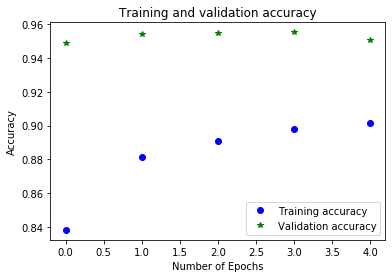

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'g*', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.show()

#Making Prediction

In [0]:
# upload image to classify wheter dog or cat
# the result is dealing with probabilty based on model accuracy before

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving download.jfif to download (1).jfif
[7.812371e-06]
download.jfif is a cat
